In [116]:
import itertools
from tqdm import tqdm
from time import sleep
from math import sqrt
from multiprocessing import Pool
from itertools import product
import matplotlib
from matplotlib import pyplot as plt

import numpy as np

font = {'size'   : 30}

matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 10, 8
matplotlib.rcParams['lines.linewidth'] = 3
props = dict(boxstyle='round', ec='black', fc='white')

deltaD = 0.1

Defines and evaluates denominators in the RG equations. The denominators in the RG equations are
$$
d_0 = \omega - \frac{1}{2}\left(D - \mu\right) - \frac{U}{2} + \frac{K}{2}
$$
$$
d_1 = \omega - \frac{1}{2}\left(D - \mu\right) + \frac{U}{2} + \frac{J}{2}
$$
$$
d_2 = \omega - \frac{1}{2}\left(D - \mu\right) + \frac{J}{4} + \frac{K}{4}
$$

In [117]:
def den(w, D, U, J, K):
    d0 = w - 0.5 * D - U/2 + K/2
    d1 = w - 0.5 * D + U/2 + J/2
    d2 = w - 0.5 * D + J/4 + K/4
    return np.array([d0, d1, d2])

# RG Equations

The RG equations for the symmetric spin-charge Anderson-Kondo are 

$$
\Delta U = 4|V|^2 \left[\frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{U}{2} + \frac{1}{2}J}  - \frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) - \frac{U}{2} + \frac{1}{2}K}\right] + \sum_{k<\Lambda_j} \frac{3}{4}\frac{K^2 - J^2}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K}
$$

$$
\Delta V = \frac{V K}{16}\left(\frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) - \frac{U}{2} + \frac{1}{2}K} + \frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K} \right) - \frac{3VJ}{4}\left( \frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{U}{2} + \frac{1}{2}J} + \frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K} \right)
$$

$$
\Delta J = - J^2\left(\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K\right)^{-1}
$$

$$
\Delta K = - K^2\left(\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K\right)^{-1}
$$

In shorthand notation, we have
$$\Delta U = 4|V|^2 \left[\frac{1}{d_1}  - \frac{1}{d_0}\right] + \sum_{k<\Lambda_j} \frac{3}{4}\frac{K^2 - J^2}{d_2}\\
\Delta V = \frac{V K}{16}\left(\frac{1}{d_0} + \frac{1}{d_2} \right) - \frac{3VJ}{4}\left( \frac{1}{d_1} + \frac{1}{d_2} \right)\\
\Delta J = - \frac{J^2}{d_2},\quad \Delta K = - \frac{K^2}{d_2}
$$
The following equation accepts the coupling values at the $j^{th}$ step of the RG, applies the RG equations on them and returns the couplings for the $(j-1)^{th}$ step. _If any coupling changes sign, it is set to 0._

In [118]:
def rg(w, D, U, V, J, K, flags):
    rho = 2/deltaD
    n = rho*deltaD
    dens = den(w, D, U, J, K)
    deltaU = int(flags[2])*(-4 * V**2 * (1/dens[0] - 1/dens[1]) - (3* (J**2 - K**2)/8) * (D*n/deltaD) / dens[2])
    deltaV = int(flags[2])*((1/16) * K * V * (1/dens[0] - 1/dens[2]) - (3/4) * J * V * (1/dens[1] + 1/dens[2]))
    deltaJ = - int(flags[2]) * J**2 / dens[2]
    deltaK = - int(flags[2]) * K**2 / dens[2]

    U = 0 if (U + n*deltaU) * U <= 0 else U + n*deltaU
    V = 0 if (V + n*deltaV) * V <= 0 else V + n*deltaV
    J = 0 if (J + n*deltaJ) * J <= 0 else J + n*deltaJ
    K = 0 if (K + n*deltaK) * K <= 0 else K + n*deltaK

    return U, V, J, K

The following function does one complete RG for a given set of bare couplings and returns arrays of the flowing couplings.

In [119]:
def complete_RG(w_, D0, U0, V0, J0, K0):
    U = [U0]
    V = [V0]
    J = [J0]
    K = [K0]
    E = [D0]
    w = w_(D0)
    old_den = den(w, D0, U[-1], J[-1], K[-1])
    for D in np.arange(D0, 0, -deltaD):
        w = w_(D)
        new_den = den(w, D, U[-1], J[-1], K[-1])
        flags = old_den * new_den > 0
        if not flags[2]:
            break
        old_den = new_den
        U_j, V_j, J_j, K_j = rg(w, D, U[-1], V[-1], J[-1], K[-1], flags)
        U.append(U_j)
        V.append(V_j)
        J.append(J_j)
        K.append(K_j)
        E.append(D - deltaD)
        
    return np.array(E), np.array(U), np.array(V), np.array(J), np.array(K)

# 1. $V=0$

First we will look at the simplified case of $V=0$. Since the RG equation for $V$ involves $V$, it will not flow. We need to look only at $U$, $J$ and $K$. Depending on the value of $\omega$, the denominator can be either positive or negative. We look at the two cases separately.

In [120]:
D0 = 20
V0 = 0

In [121]:
def plot(x,y,ylabels,locn,bare,log=[]):
    if log == []:
        log = [0]*len(y)
    for yi,yl,logi in zip(y, ylabels, log):
        plt.plot(x,yi)
        plt.ylabel(yl)
        plt.xlabel(r'RG Step')
        text = '\n'.join([r"$J_0={}, K_0={}, V_0 = {}$,".format(*bare[:3]), r"$U_0={}, D_0={}, \omega={}\times D$".format(*bare[3:])])
        plt.text(locn[0], locn[1], text, bbox=props, size=25, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.tight_layout()
        if logi == 1:
            plt.yscale("log")
        plt.show()


## a. $\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K>0$ (high $\omega$):

These aren't truly URG fixed points because the denominator will not converge towards zero.

### i. $J=K$

Since $\Delta U \propto K^2 - J^2$, $U$ will be marginal here.

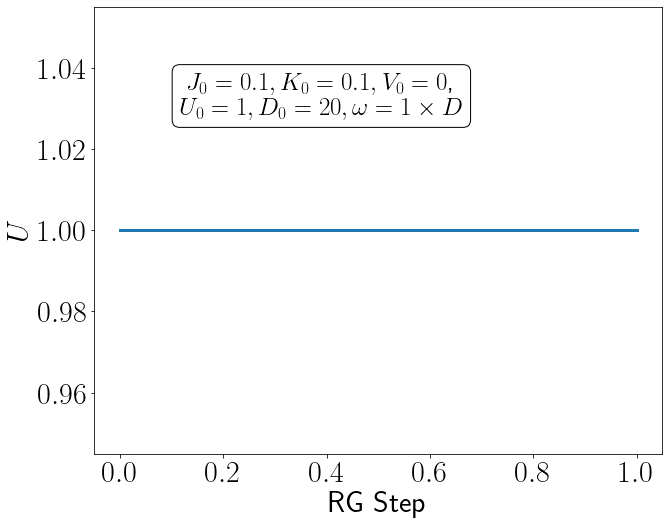

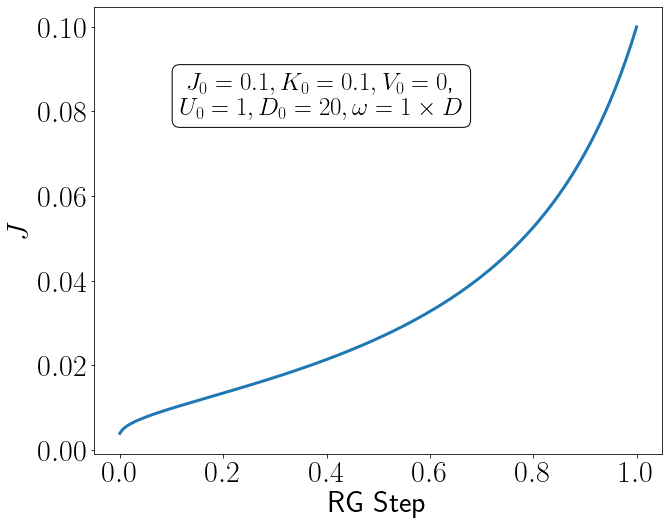

In [122]:
U0 = 1
J0 = K0 = 0.1
E,U,V,J,K = complete_RG(lambda x: x, D0, U0, V0, J0, K0)
steps = np.array(E)/D0
plot(steps, (U, J), (r"$U$", r"$J$"), (0.4,0.8), (J0, K0, 0, U0, D0, 1))

### ii. $J > K$

$U$ will be irrelevant here.

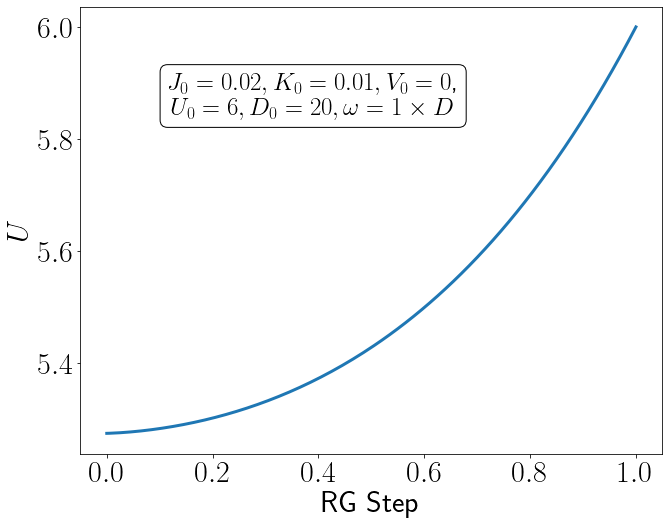

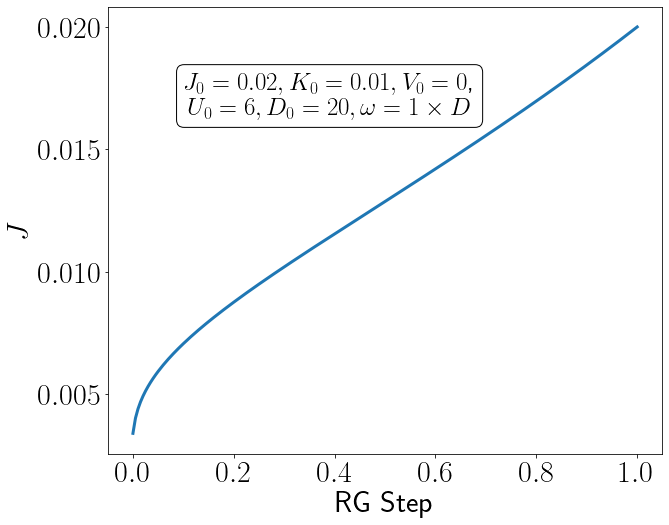

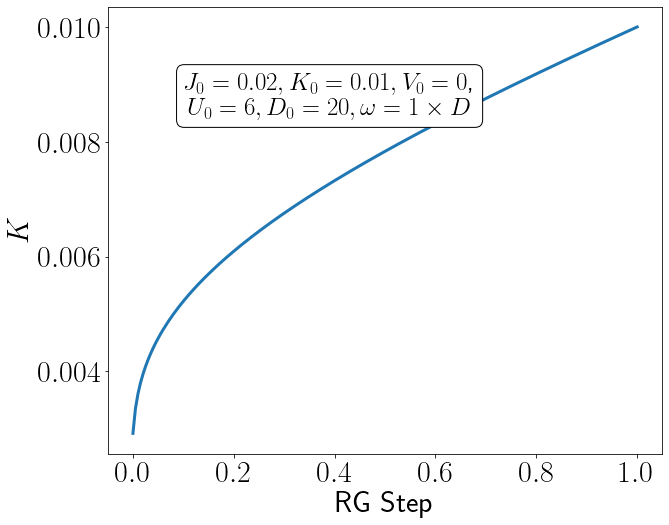

In [123]:
U0 = 6
J0 = 0.02
K0 = 0.01
E,U,V,J,K = complete_RG(lambda x: x, D0, U0, V0, J0, K0)
steps = np.array(E)/D0
plot(steps, (U, J, K), (r"$U$", r"$J$", r"$K$"), (0.4,0.8), (J0, K0, 0, U0, D0, 1))

### iii. $J < K$

$U$ will be relevant here.

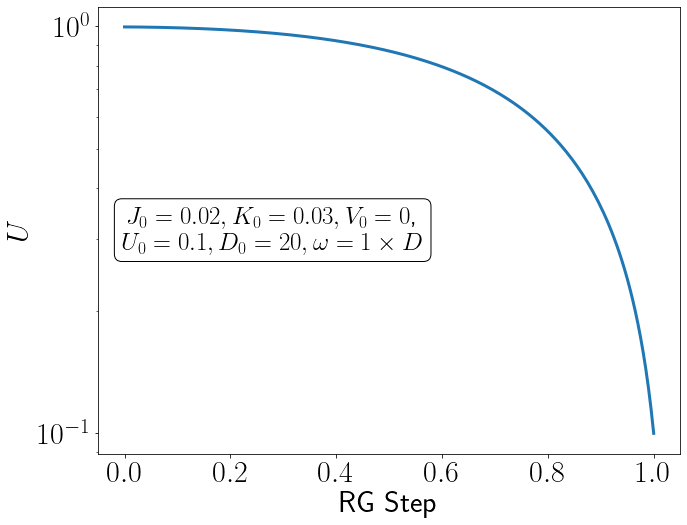

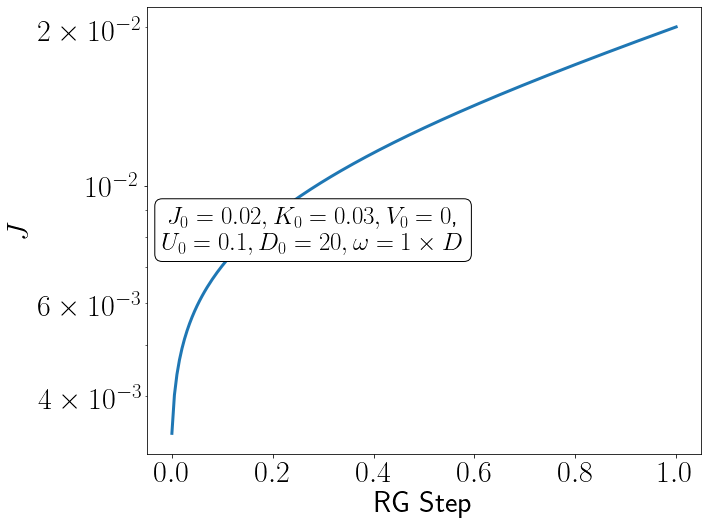

In [125]:
U0 = 0.1
J0 = 0.02
K0 = 0.03

E,U,V,J,K = complete_RG(lambda x:x, D0, U0, V0, J0, K0)
steps = np.array(E)/D0
plot(steps, (U, J), (r"$U$", r"$J$"), (0.3,0.5), (J0, K0, 0, U0, D0, 1), log=[1,1])

## b. $\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K<0$ (low $\omega$):

This is the regime where we achieve true strong-coupling fixed points in $J,K$. The signature of $K^2 - J^2$ will determine whether $U$ is relevant or irrelevant.

### i. $J>K$

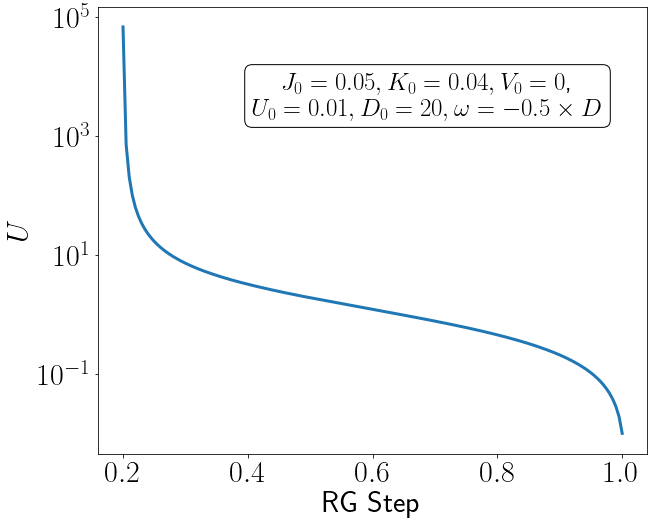

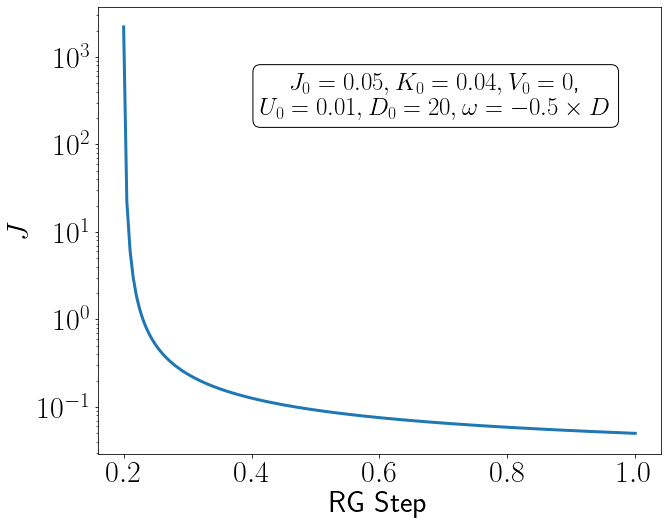

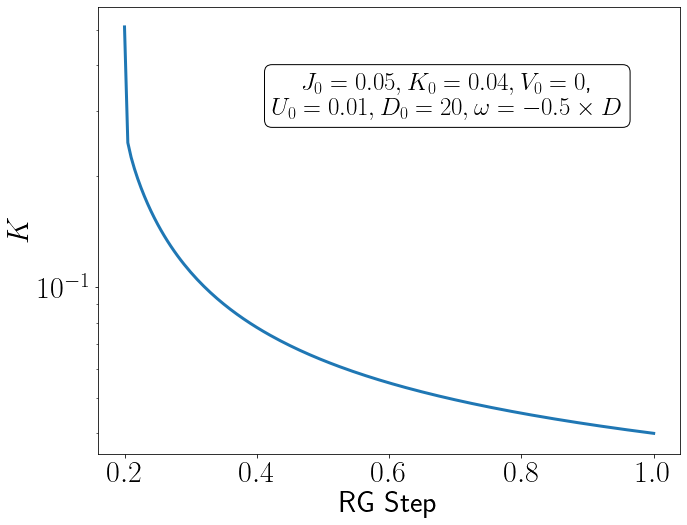

In [126]:
U0 = 0.01
J0 = 0.05
K0 = 0.04

E,U,V,J,K = complete_RG(lambda x:-x, D0, U0, V0, J0, K0)
steps = np.array(E)/D0

plot(steps, (U, J, K), (r"$U$", r"$J$", r"$K$"), (0.6,0.8), (J0, K0, 0, U0, D0, -0.5), log=[1,1,1])

### i. $J<K$

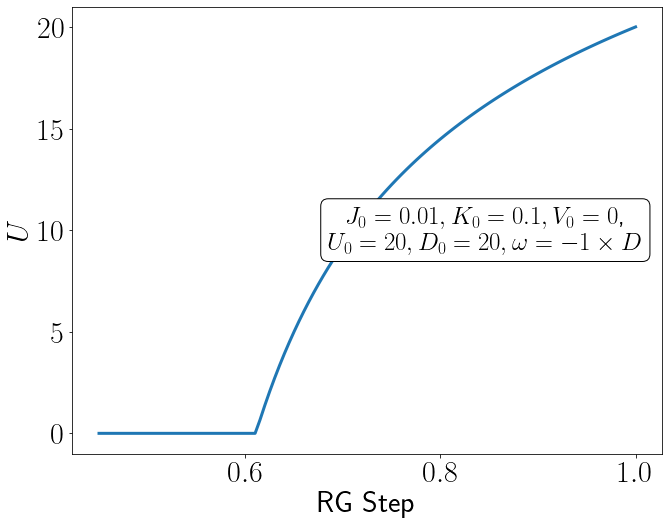

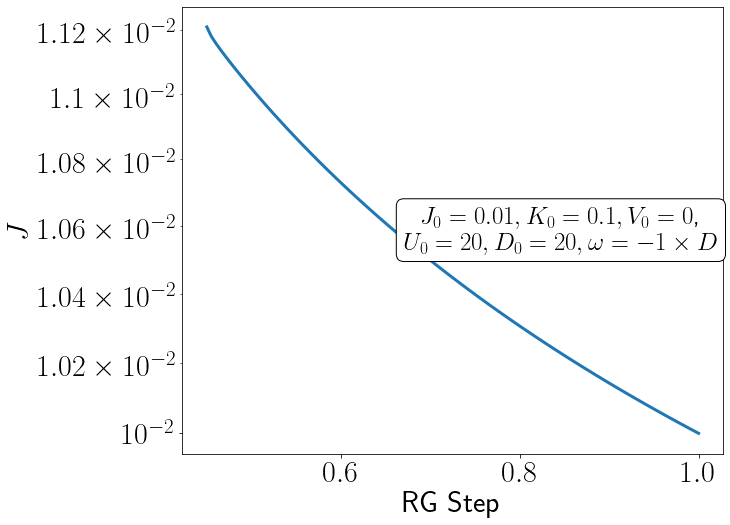

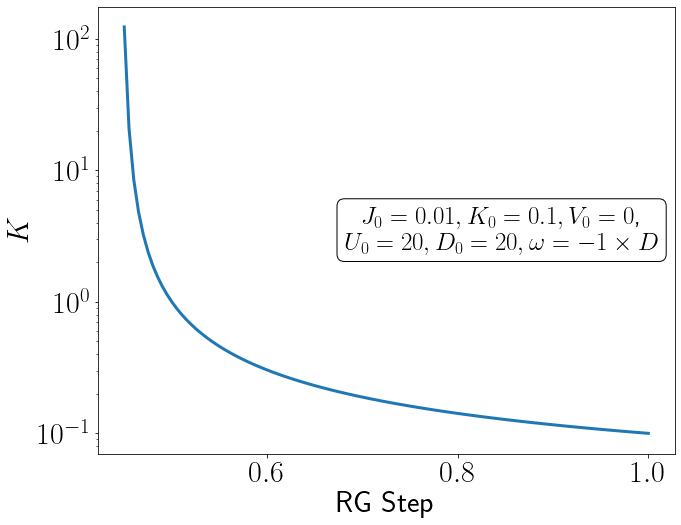

In [128]:
U0 = 20
J0 = 0.01
K0 = 0.1

E,U,V,J,K = complete_RG(lambda x: -x, D0, U0, V0, J0, K0)
steps = np.array(E)/D0

plot(steps, (U, J, K), (r"$U$", r"$J$", r"$K$"), (0.7,0.5), (J0, K0, 0, U0, D0, -1), log=[0,1,1])

To wrap up the $V=0$ case, we look at an RG-invariant:

$\frac{\Delta J}{\Delta K} = \frac{J^2}{K^2} \implies \frac{1}{J} - \frac{1}{K} = \frac{1}{J_0} - \frac{1}{K_0}$

Note that this is an invariant even when $V$ is turned on.

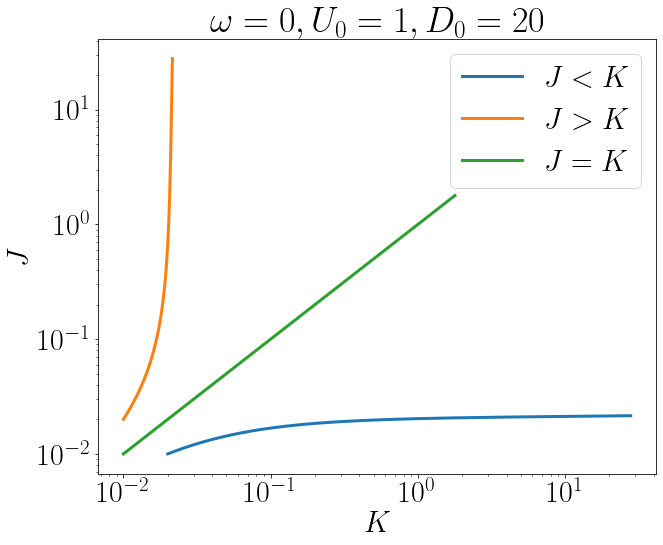

In [129]:
w = lambda x:0
U0 = 1
J0 = 0.01
K0 = 0.02
E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
plt.xlabel(r"$K$")
plt.ylabel(r"$J$")
plt.plot(K, J, label=r'$J<K$')
J0 = 0.02
K0 = 0.01
E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
plt.plot(K, J, label=r'$J>K$')
J0 = 0.01
K0 = 0.01
E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
plt.plot(K, J, label=r'$J=K$')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title(r"$\omega = {}, U_0 = {}, D_0={}$".format(0, U0, D0))
plt.show()

# 2. $V > 0$

$$
	\Delta U = 4|V|^2 \left[\frac{1}{\omega - \frac{\epsilon_q}{2} + \frac{U}{2} + \frac{1}{2}J}  - \frac{1}{\omega - \frac{\epsilon_q}{2} - \frac{U}{2} + \frac{1}{2}K}\right] + \sum_{k<\Lambda_j} \frac{3}{4}\frac{K^2 - J^2}{\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K}
$$
$$
	\Delta V = \frac{V K}{16}\left(\frac{1}{\omega - \frac{\epsilon_q}{2} - \frac{U}{2} + \frac{1}{2}K} + \frac{1}{\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K} \right) - \frac{3VJ}{4}\left( \frac{1}{\omega - \frac{\epsilon_q}{2} + \frac{U}{2} + \frac{1}{2}J} + \frac{1}{\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K} \right)
$$
$$
	\Delta J = - \frac{J^2}{\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K}
$$
$$
	\Delta K = - \frac{K^2}{\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K}
$$

## $U>0, J>0, K<0$

In [156]:
D0 = 50
V0 = D0/100
J0 = D0/100
K0 = -J0
U0 = D0/5

### $\omega < \frac{D_0}{2} - U - $

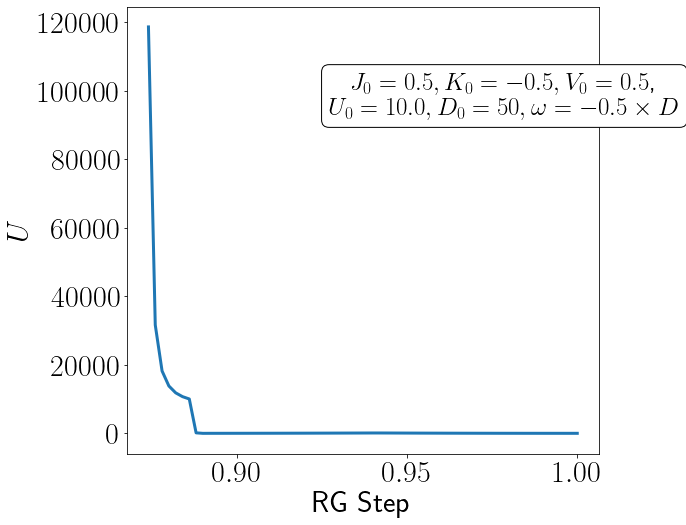

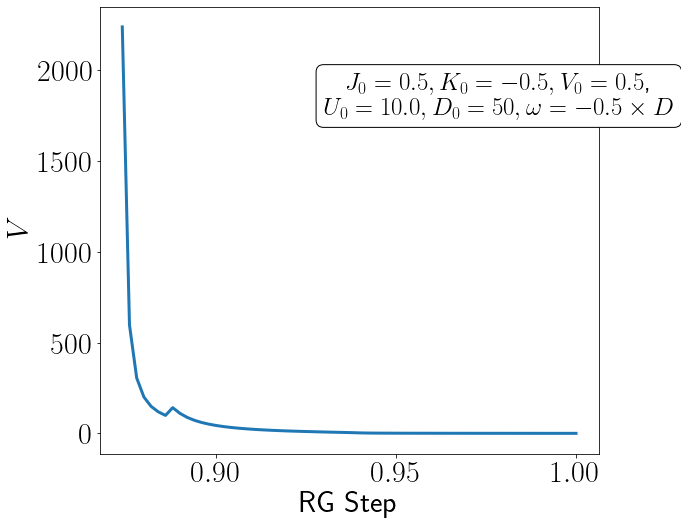

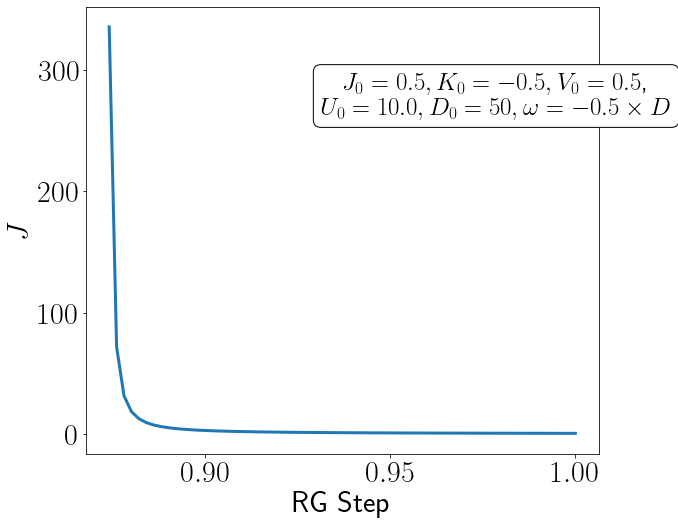

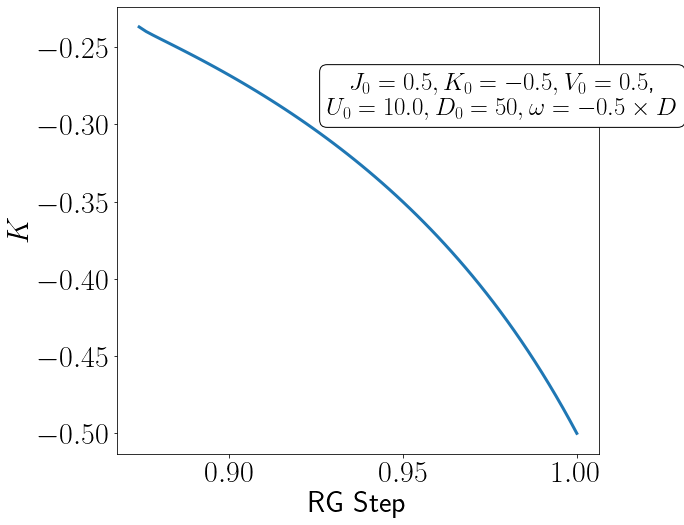

In [157]:
w = lambda x: -D0/2 - U0
E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
steps = np.array(E)/D0
plot(steps, (U, V, J, K),(r"$U$", r"$V$", r"$J$", r"$K$"), (0.8,0.8), (J0, K0, V0, U0, D0, -0.5))

In [ ]:
D0 = 20
V0 = 0.1
J0 = 0.01
K0 = -J0
w = lambda x: -x/2

for U0 in [1, 0.5, 0.05, 0]:
    E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
    J = np.array(J)
    U = np.array(U)

    if U0 != 0:
        plt.plot(J[np.where(U > 0)], U[np.where(U > 0)], label=r"$U_0 = {}$".format(U0))
        rang = len(J[np.where(U > 0)])
    else:
        plt.plot(J[:rang], U[:rang], label=r"$U_0 = {}$".format(U0))
    plt.ylabel(r"$U$")
    plt.xlabel(r"$J$")
plt.legend()
plt.title(r"$V_0 = {}, J_0 = {}, K_0 = {}, D_0 = {}, \omega = {}$".format(V0, J0, K0, D0, 0))
plt.show()

In [ ]:
D0 = 20
V0 = 0.1
J0 = 0.02
K0 = 0
w = lambda x: -x/2
U0 = 0.5

E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
steps = np.array(E)/D0
U = np.array(U)
V = np.array(V)
J = np.array(J)

plt.plot(J[U>0], U[U>0])
plt.xlabel(r"$J$")
plt.ylabel(r"$U$")
plt.show()
plt.plot(V[U>0], U[U>0])
plt.ylabel(r"$U$")
plt.xlabel(r"$V$")
# plt.suptitle(r"$U_0 = {}, V_0 = {}, J_0 = {}, K_0 = {}, D_0 = {}, \omega = {}\times D$".format(U0, V0, J0, K0, D0, -0.5), y=0.95)
# plt.show()

In [ ]:
def plot(x, y, xlabel, ylabel, ax):
    ax.plot(x,y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # ax.set_yscale("log")
    

D0 = 10
U0 = -2 * D0
V0 = 1
K0 = abs(V0**2/U0)
J0 = -K0
w = lambda x:-x

E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
steps = np.array(E)/D0
plt.plot(steps, U)
plt.show()
plt.plot(steps, K)
plt.show()
plt.plot(steps, V)
# plot(steps, np.array(U), r"RG steps", r"$-|U|$", ax[0])
# plot(steps, K, r"RG steps", r"$K$", ax[1])

# plt.suptitle(r"$U_0 = {}, V_0 = {}, J_0 = {}, K_0 = {}, D_0 = {}, \omega = {}\times D$".format(U0, V0, J0, K0, D0, -0.5), y=0.9)
# fig.tight_layout()
# plt.show()

## Scaling of $J^*$ and $V^*$ with system size

In [ ]:
def plot_vs_D(w, U0, V0, J0, K0, D0_range):
    couplings = [[], [], []]
    x = []
    for D0 in tqdm(D0_range):
        E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
        if V[-1] == 0:
            continue
    
        couplings[0].append(V[-1])
        couplings[1].append(J[-1])
        couplings[2].append(K[-1])
        x.append(D0)
    
    for coupling, ylabel in zip(couplings, [r"$V^*$", r"$J^*$", r"$K^*$"]):
        plt.scatter(x, couplings[0], color="r")
        plt.xscale("log")
        plt.yscale("log")
        plt.ylabel(ylabel)
        plt.xlabel(r"$D_0$")
        plt.show()
    
V0 = 0.1
K0 = 0.01
U0 = 10
J0 = 0.2
w = 0
D0_range = 10**np.linspace(0, 7, 6)
plot_vs_D(w, U0, V0, J0, K0, D0_range)

### First Quadrant

## Scaling of $\frac{j}{v}$ with system size

In [ ]:
def plot_ratio(args):
    U0, V0 = args
    for D0 in tqdm(D0_range):
        w = 0
        E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
        if V[-1] == 0:
            continue
        count = E[-1]*2/deltaD
        gamma = (((3*J[-1] + K[-1])*sqrt(count) + 2*U[-1])/V[-1])
        plt.scatter(D0, gamma, color='r')


    plt.xscale("log")
    plt.yscale("log")
    plt.title(r"$U_0={}, V_0={}$".format(U0,V0))
    plt.show()

In [ ]:
D0_range = 10**np.linspace(0, 5, 9)
J0 = 0.01
K0 = 0.2
U0 = 10
V0 = 0.01
plot_ratio((U0, V0))

In [ ]:
D0_range = 10**np.linspace(0, 5, 10)
J0 = 0.2
K0 = 0.01
U0 = 10
V0 = 0.01
plot_ratio((U0, V0))
V0 = 1
plot_ratio((U0, V0))

## Ground state

$$
\Delta E = 	E_-^2 - E_c^2 = \frac{1}{2}\epsilon_d - \frac{3j + k}{8} + k - \sqrt{4v^2 + \left(\frac{3j+k}{8} -\frac{1}{2} \epsilon_d\right) ^2}
$$

In [ ]:
D0 = 20
J0 = 1
V0 = 0.7
w = 0
signs = []
K0_range = np.linspace(2,0,20,endpoint=True)
for K0 in K0_range:
    U0 = 0.4 * np.sign(J0 - K0)
    E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
    count = E[-1]/deltaD
    j = J[-1] * count
    k = K[-1] * count
    v = V[-1] * sqrt(count)
    U = U[-1]
    delta = -U/4 - 3*j/8 + 7*j/8 - sqrt(4*v**2 + ((3*j+k)/8 + U/4)**2)
    signs.append(np.sign(delta))

signs = np.array(signs)
plt.title(r"$U_0 = \pm 0.4, V_0=0.7, J_0=1$")
plt.plot((K0_range - J0)[signs > 0], signs[signs > 0])
plt.plot((K0_range - J0)[signs < 0], signs[signs < 0])
plt.xlabel(r"$K_0 - J_0$")
plt.ylabel(r"sign ($\Delta E_g$)")
plt.show()